In [116]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as sps


sns.set()
pd.set_option("display.precision", 2)

# SCRAPES THE LATEST DATA FROM WORLDOMETERS
url = 'https://www.worldometers.info/coronavirus/#countries'

r = requests.get(url)

c = r.content

soup = bs(c,'html.parser')

foo = soup.findAll('div',{'class' : 'tab-content'})
print (len(foo))

the_div = foo[2]

tbody = the_div.tbody

rows = tbody.findAll('tr')

countries = dict()

for r in rows:
    td = r.findAll('td')
    name = td[0].get_text().strip()
    confirmed = td[1].get_text().strip()
    inc = td[2].get_text().strip()
    deaths = td[3].get_text().strip()
    d_inc = td[4].get_text().strip()
    recovered = td[5].get_text().strip()
    active_cases = td[6].get_text().strip()
    serious = td[7].get_text().strip()
    conf_p_M = td[8].get_text().strip()
    countries[name] = [confirmed,inc,deaths,d_inc,
                       recovered,active_cases,serious,conf_p_M]
    
cols = ['confirmed','inc','dead','dead_inc','recovered',
        'active_cases','serious','confirmed_per_M']

df = pd.DataFrame.from_dict(countries)
df = df.T
df.columns = cols

df.replace('N/A',np.nan,inplace=True)

df[['inc','dead_inc']] = df[['inc','dead_inc']].apply(
    lambda x : x.str.replace('+',''))

df[['confirmed','dead','recovered','active_cases',
    'serious','inc','dead_inc','confirmed_per_M']] = \
    df[['confirmed','dead','recovered','active_cases',
        'serious','inc','dead_inc','confirmed_per_M']].apply(
    lambda x : x.str.replace(',',''))

df[cols] = df[cols].apply(lambda x: x.replace('',np.nan))


df[cols] = df[cols].astype(float)
df['yesterday'] = df['confirmed'] - df['inc']
df['factor'] = df['confirmed'] / df['yesterday']
cols  = ['confirmed', 'yesterday','inc', 'factor','dead', 'dead_inc', 'recovered', 'active_cases',
       'serious', 'confirmed_per_M']

df = df[cols]

#df['factor'].loc[df['factor'] == np.inf]
df['factor'] = df['factor'].replace(np.inf,np.nan)
df['dead_pct'] = 100 * df['dead'] / df['confirmed']
df['dead'] = df['dead'].fillna(0)
df['dead_factor'] = df['dead'].div (df['dead'] - df['dead_inc'])
df['dead_factor'].replace(np.inf,np.nan,inplace=True)

### add population data to calculate dead_per_M

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

df['dead_per_M'] = df['dead'].div (country_populations['population'] / 1e6)

###

df.head(40)


3


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M
North America,8.52e+05,8.51e+05,912.0,1.00,45476.0,43.0,89163.0,7.18e+05,15208.0,NaN,5.34,1.00,NaN
Europe,1.12e+06,1.11e+06,6256.0,1.01,104574.0,83.0,326249.0,6.89e+05,26137.0,NaN,9.34,1.00,NaN
Asia,3.99e+05,3.96e+05,2119.0,1.01,15157.0,25.0,186995.0,1.96e+05,6304.0,NaN,3.80,1.00,NaN
South America,8.66e+04,8.65e+04,106.0,1.00,4082.0,3.0,37940.0,4.46e+04,9452.0,NaN,4.71,1.00,NaN
Oceania,8.19e+03,8.16e+03,22.0,1.00,84.0,1.0,5728.0,2.37e+03,54.0,NaN,1.03,1.01,NaN
Africa,2.42e+04,2.42e+04,38.0,1.00,1164.0,NaN,6471.0,1.66e+04,174.0,NaN,4.81,NaN,NaN
,7.21e+02,NaN,NaN,NaN,15.0,NaN,644.0,6.20e+01,7.0,NaN,2.08,NaN,NaN
World,2.49e+06,2.48e+06,9453.0,1.00,170552.0,155.0,653190.0,1.67e+06,57336.0,319.0,6.85,1.00,NaN
USA,7.93e+05,7.93e+05,179.0,1.00,42518.0,4.0,72389.0,6.78e+05,13951.0,2396.0,5.36,1.00,128.45
Spain,2.00e+05,NaN,NaN,NaN,20852.0,NaN,80587.0,9.88e+04,7371.0,4282.0,10.42,NaN,445.99


In [117]:
df.to_pickle('scrape_df.pkl')
df.agg(['sum','max','min','mean','median','count'])


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M
sum,7.47e+06,6.07e+06,28359.00,49.63,511656.00,465.00,1.96e+06,5.00e+06,172008.00,149629.23,848.18,28.42,6453.40
max,2.49e+06,2.48e+06,9453.00,1.20,170552.00,155.00,6.53e+05,1.67e+06,57336.00,13616.00,22.22,1.20,1149.39
min,1.00e+00,5.00e+00,1.00,1.00,0.00,1.00,1.00e+00,0.00e+00,1.00,0.03,0.12,1.00,0.00
mean,3.40e+04,1.27e+05,590.81,1.03,2325.71,17.22,9.51e+03,2.27e+04,1178.14,709.14,4.85,1.05,32.76
median,4.56e+02,1.92e+03,23.00,1.02,9.00,3.00,1.24e+02,2.48e+02,14.00,130.00,3.52,1.03,2.11
count,2.20e+02,4.80e+01,48.00,48.00,220.00,27.00,2.06e+02,2.20e+02,146.00,211.00,175.00,27.00,197.00


In [118]:
today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
file_prefix = 'snapshots/corona_snapshot_'
filename = file_prefix + today.replace(' ','_').replace(':','_') + '.pkl'
df['datetime'] = [today] * len(df)
df.set_index([df.index,'datetime'],drop=True).to_pickle(filename)
df.head(8)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
North America,8.52e+05,8.51e+05,912.0,1.00,45476.0,43.0,89163.0,7.18e+05,15208.0,NaN,5.34,1.00,NaN,2020-04-21 09:57:02
Europe,1.12e+06,1.11e+06,6256.0,1.01,104574.0,83.0,326249.0,6.89e+05,26137.0,NaN,9.34,1.00,NaN,2020-04-21 09:57:02
Asia,3.99e+05,3.96e+05,2119.0,1.01,15157.0,25.0,186995.0,1.96e+05,6304.0,NaN,3.80,1.00,NaN,2020-04-21 09:57:02
South America,8.66e+04,8.65e+04,106.0,1.00,4082.0,3.0,37940.0,4.46e+04,9452.0,NaN,4.71,1.00,NaN,2020-04-21 09:57:02
Oceania,8.19e+03,8.16e+03,22.0,1.00,84.0,1.0,5728.0,2.37e+03,54.0,NaN,1.03,1.01,NaN,2020-04-21 09:57:02
Africa,2.42e+04,2.42e+04,38.0,1.00,1164.0,NaN,6471.0,1.66e+04,174.0,NaN,4.81,NaN,NaN,2020-04-21 09:57:02
,7.21e+02,NaN,NaN,NaN,15.0,NaN,644.0,6.20e+01,7.0,NaN,2.08,NaN,NaN,2020-04-21 09:57:02
World,2.49e+06,2.48e+06,9453.0,1.00,170552.0,155.0,653190.0,1.67e+06,57336.0,319.0,6.85,1.00,NaN,2020-04-21 09:57:02


In [119]:
import glob
files = [f for f in glob.glob('./' + file_prefix +'*')]

timeline_df = pd.DataFrame()

for f in files:
    temp = pd.read_pickle(f)
    timeline_df = pd.concat([timeline_df,temp],axis=0)
    
timeline_df.sort_index(inplace=True)
timeline_df['dead'] = timeline_df['dead'].fillna(0)
timeline_df

confirmed  yesterday  inc  factor  dead  \
         datetime                                                       
         2020-04-09 09:30:48      721.0        NaN  NaN     NaN  13.0   
         2020-04-10 17:13:28      721.0        NaN  NaN     NaN  13.0   
         2020-04-11 08:52:14      721.0        NaN  NaN     NaN  13.0   
         2020-04-11 17:10:54      721.0        NaN  NaN     NaN  13.0   
         2020-04-12 17:32:27      721.0        NaN  NaN     NaN  13.0   
...                                 ...        ...  ...     ...   ...   
Zimbabwe 2020-04-18 15:08:03       24.0        NaN  NaN     NaN   3.0   
         2020-04-18 17:29:49       24.0        NaN  NaN     NaN   3.0   
         2020-04-19 00:07:46       25.0       24.0  1.0    1.04   3.0   
         2020-04-20 21:03:03       25.0        NaN  NaN     NaN   3.0   
         2020-04-21 09:57:02       25.0        NaN  NaN     NaN   3.0   

                              dead_inc  recovered  active_cases  serious  \
         datetime                                                          
         2020-04-09 09:30:48       NaN      619.0          89.0     10.0   
         2020-04-10 17:13:28       NaN      619.0          89.0     10.0   
         2020-04-11 08:52:14       NaN      619.0          89.0     10.0   
         2020-04-11 17:10:54       NaN      619.0          89.0     10.0   
         2020-04-12 17:32:27       NaN      619.0          89.0     10.0   
...                                ...        ...           ...      ...   
Zimbabwe 2020-04-18 15:08:03       NaN        2.0          19.0      NaN   
         2020-04-18 17:29:49       NaN        2.0          19.0      NaN   
         2020-04-19 00:07:46       NaN        2.0          20.0      NaN   
         2020-04-20 21:03:03       NaN        2.0          20.0      NaN   
         2020-04-21 09:57:02       NaN        2.0          20.0      NaN   

                              confirmed_per_M  dead_pct  dead_factor  \
         datetime                                                      
         2020-04-09 09:30:48              NaN       1.8          NaN   
         2020-04-10 17:13:28              NaN       1.8          NaN   
         2020-04-11 08:52:14              NaN       1.8          NaN   
         2020-04-11 17:10:54              NaN       1.8          NaN   
         2020-04-12 17:32:27              NaN       1.8          NaN   
...                                       ...       ...          ...   
Zimbabwe 2020-04-18 15:08:03              2.0      12.5          NaN   
         2020-04-18 17:29:49              2.0      12.5          NaN   
         2020-04-19 00:07:46              2.0      12.0          NaN   
         2020-04-20 21:03:03              2.0      12.0          NaN   
         2020-04-21 09:57:02              2.0      12.0          NaN   

                              dead_per_M  
         datetime                         
         2020-04-09 09:30:48         NaN  
         2020-04-10 17:13:28         NaN  
         2020-04-11 08:52:14         NaN  
         2020-04-11 17:10:54         NaN  
         2020-04-12 17:32:27         NaN  
...                                  ...  
Zimbabwe 2020-04-18 15:08:03         0.2  
         2020-04-18 17:29:49         0.2  
         2020-04-19 00:07:46         0.2  
         2020-04-20 21:03:03         0.2  
         2020-04-21 09:57:02         0.2  

[47701 rows x 13 columns]

In [120]:
timeline_group = timeline_df.groupby(level=0)

a_country = timeline_group.get_group('Sweden')

In [121]:
non_duplicates = ( ( a_country['confirmed'] != a_country['confirmed'].shift() )  | (
    a_country['dead'] != a_country['dead'].shift()))

a_country = a_country[non_duplicates]
a_country

confirmed  yesterday    inc  factor    dead  \
       datetime                                                           
Sweden 2020-03-15 15:50:08     1024.0      961.0   63.0    1.07     2.0   
       2020-03-15 19:43:02     1024.0      961.0   63.0    1.07     3.0   
       2020-03-15 21:46:07     1040.0      961.0   79.0    1.08     3.0   
       2020-03-16 12:09:38     1043.0     1040.0    3.0    1.00     3.0   
       2020-03-16 13:03:36     1043.0     1040.0    3.0    1.00     6.0   
...                               ...        ...    ...     ...     ...   
       2020-04-15 16:57:44    11927.0    11445.0  482.0    1.04  1203.0   
       2020-04-16 18:03:48    12540.0    11927.0  613.0    1.05  1333.0   
       2020-04-17 19:45:25    13216.0    12540.0  676.0    1.05  1400.0   
       2020-04-18 15:08:03    13822.0    13216.0  606.0    1.05  1511.0   
       2020-04-20 21:03:03    14777.0    14385.0  392.0    1.03  1580.0   

                            dead_inc  recovered  active_cases  serious  \
       datetime                                                          
Sweden 2020-03-15 15:50:08       NaN        1.0        1021.0      2.0   
       2020-03-15 19:43:02       1.0        1.0        1020.0      2.0   
       2020-03-15 21:46:07       1.0        1.0        1036.0      2.0   
       2020-03-16 12:09:38       NaN        1.0        1039.0      2.0   
       2020-03-16 13:03:36       3.0        1.0        1036.0      2.0   
...                              ...        ...           ...      ...   
       2020-04-15 16:57:44     170.0      381.0       10343.0    954.0   
       2020-04-16 18:03:48     130.0      550.0       10657.0    996.0   
       2020-04-17 19:45:25      67.0      550.0       11266.0    482.0   
       2020-04-18 15:08:03     111.0      550.0       11761.0   1054.0   
       2020-04-20 21:03:03      40.0      550.0       12647.0    521.0   

                            confirmed_per_M  dead_pct  dead_factor  dead_per_M  
       datetime                                                                 
Sweden 2020-03-15 15:50:08            101.4      0.20          NaN         NaN  
       2020-03-15 19:43:02            101.4      0.29          NaN         NaN  
       2020-03-15 21:46:07            103.0      0.29          NaN         NaN  
       2020-03-16 12:09:38            103.3      0.29          NaN         NaN  
       2020-03-16 13:03:36            103.3      0.58          NaN         NaN  
...                                     ...       ...          ...         ...  
       2020-04-15 16:57:44           1181.0     10.09         1.16      119.12  
       2020-04-16 18:03:48           1242.0     10.63         1.11      131.99  
       2020-04-17 19:45:25           1309.0     10.59         1.05      138.62  
       2020-04-18 15:08:03           1369.0     10.93         1.08      149.61  
       2020-04-20 21:03:03           1463.0     10.69         1.03      156.45  

[68 rows x 13 columns]

In [122]:
resample = a_country.droplevel(0)
resample.index = pd.DatetimeIndex(resample.index)
#resample = resample.resample('180T').bfill()
resample = resample.resample('D').bfill()

index = pd.to_datetime(resample.index)

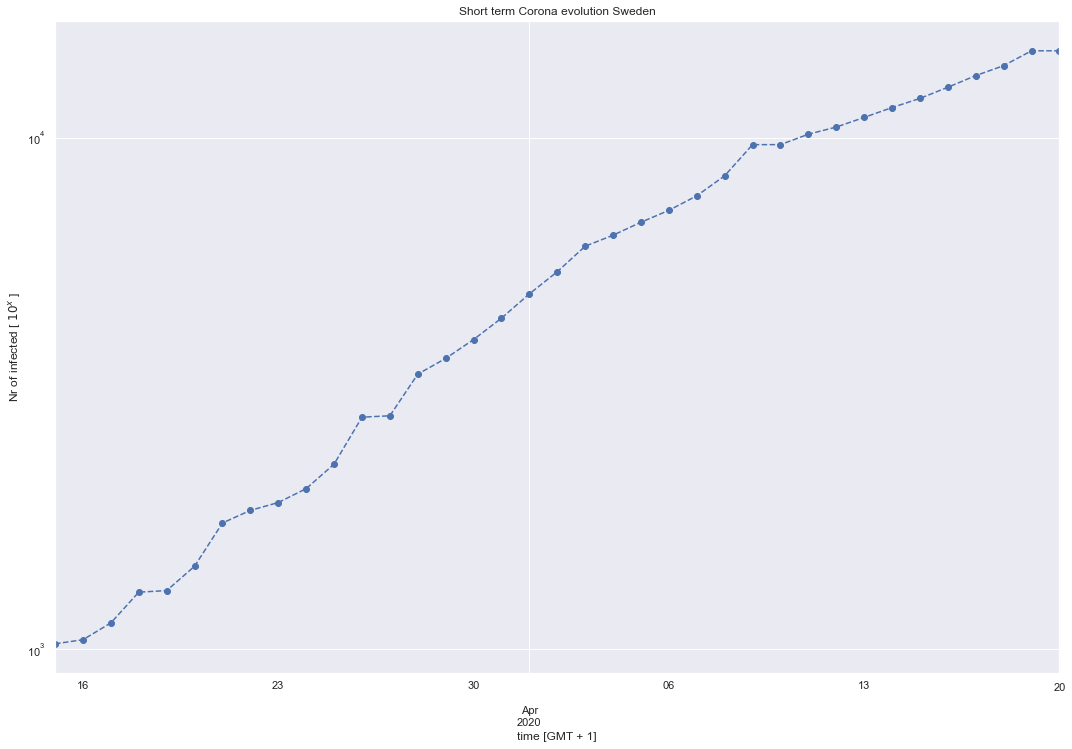

In [123]:


plt.figure(figsize=(18,12))
plt.title('Short term Corona evolution {}'.format(a_country.index[0][0]))
resample['confirmed'].plot(style ='o--')
#plt.xticks(rotation=90)
#plt.xticks(np.arange(len(index)),index.values)
plt.xlabel('time [GMT + 1]')

#plt.ylabel('Nr of infected')
plt.ylabel(r'Nr of infected [ $10^{x}$ ]')
plt.yscale('log')

filename = 'corona_short_term_' + a_country.index[0][0] + '.jpg'
plt.savefig (filename,format='jpg')


In [124]:
top_dead_pct = df.loc[df['confirmed'] > 500].sort_values('dead_pct',ascending=False)
top_dead_pct

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Belgium,39983.0,NaN,NaN,NaN,5828.0,NaN,8895.0,25260.0,1071.0,3450.0,14.58,NaN,502.86,2020-04-21 09:57:02
Algeria,2718.0,NaN,NaN,NaN,384.0,NaN,1099.0,1235.0,40.0,62.0,14.13,NaN,8.76,2020-04-21 09:57:02
Italy,181228.0,NaN,NaN,NaN,24114.0,NaN,48877.0,108237.0,2573.0,2997.0,13.31,NaN,398.83,2020-04-21 09:57:02
UK,124743.0,NaN,NaN,NaN,16509.0,NaN,NaN,107890.0,1559.0,1838.0,13.23,NaN,243.19,2020-04-21 09:57:02
France,155383.0,NaN,NaN,NaN,20265.0,NaN,37409.0,97709.0,5683.0,2380.0,13.04,NaN,310.46,2020-04-21 09:57:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bahrain,1907.0,NaN,NaN,NaN,7.0,NaN,769.0,1131.0,2.0,1121.0,0.37,NaN,4.11,2020-04-21 09:57:02
Uzbekistan,1657.0,1627.0,30.0,1.02,5.0,NaN,261.0,1391.0,8.0,50.0,0.30,NaN,0.15,2020-04-21 09:57:02
Djibouti,846.0,NaN,NaN,NaN,2.0,NaN,102.0,742.0,NaN,856.0,0.24,NaN,2.02,2020-04-21 09:57:02
Qatar,6015.0,NaN,NaN,NaN,9.0,NaN,555.0,5451.0,37.0,2088.0,0.15,NaN,3.12,2020-04-21 09:57:02


In [125]:
country_names = sorted(df.index.values)
#country_names

In [126]:
df.loc[df['confirmed'] > 500 ].sort_values('factor',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Singapore,9125.0,8014.0,1111.0,1.14,11.0,NaN,801.0,8313.0,23.0,1560.0,0.12,NaN,1.88,2020-04-21 09:57:02
Russia,52763.0,47121.0,5642.0,1.12,456.0,51.0,3873.0,48434.0,700.0,362.0,0.86,1.13,3.12,2020-04-21 09:57:02
Ukraine,6125.0,5710.0,415.0,1.07,161.0,10.0,367.0,5597.0,45.0,140.0,2.63,1.07,3.68,2020-04-21 09:57:02
Oman,1508.0,1410.0,98.0,1.07,8.0,1.0,238.0,1262.0,3.0,295.0,0.53,1.14,1.57,2020-04-21 09:57:02
Kazakhstan,1967.0,1852.0,115.0,1.06,19.0,NaN,452.0,1496.0,22.0,105.0,0.97,NaN,1.01,2020-04-21 09:57:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Costa Rica,662.0,NaN,NaN,NaN,6.0,NaN,124.0,532.0,8.0,130.0,0.91,NaN,1.18,2020-04-21 09:57:02
Guinea,622.0,NaN,NaN,NaN,5.0,NaN,122.0,495.0,NaN,47.0,0.80,NaN,0.38,2020-04-21 09:57:02
Albania,584.0,NaN,NaN,NaN,26.0,NaN,327.0,231.0,5.0,203.0,4.45,NaN,9.03,2020-04-21 09:57:02
Burkina Faso,581.0,NaN,NaN,NaN,38.0,NaN,357.0,186.0,NaN,28.0,6.54,NaN,1.82,2020-04-21 09:57:02


In [127]:
top_40_per_m = df.sort_values('dead_per_M',ascending=False).head(40)
top_40_per_m.head(40)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
San Marino,462.0,NaN,NaN,NaN,39.0,NaN,61.0,362.0,4.0,13616.0,8.44,NaN,1149.39,2020-04-21 09:57:02
Belgium,39983.0,NaN,NaN,NaN,5828.0,NaN,8895.0,25260.0,1071.0,3450.0,14.58,NaN,502.86,2020-04-21 09:57:02
Andorra,717.0,NaN,NaN,NaN,37.0,NaN,248.0,432.0,17.0,9280.0,5.16,NaN,478.87,2020-04-21 09:57:02
Spain,200210.0,NaN,NaN,NaN,20852.0,NaN,80587.0,98771.0,7371.0,4282.0,10.42,NaN,445.99,2020-04-21 09:57:02
Italy,181228.0,NaN,NaN,NaN,24114.0,NaN,48877.0,108237.0,2573.0,2997.0,13.31,NaN,398.83,2020-04-21 09:57:02
France,155383.0,NaN,NaN,NaN,20265.0,NaN,37409.0,97709.0,5683.0,2380.0,13.04,NaN,310.46,2020-04-21 09:57:02
UK,124743.0,NaN,NaN,NaN,16509.0,NaN,NaN,107890.0,1559.0,1838.0,13.23,NaN,243.19,2020-04-21 09:57:02
Sint Maarten,67.0,NaN,NaN,NaN,10.0,NaN,12.0,45.0,6.0,1563.0,14.93,NaN,233.23,2020-04-21 09:57:02
Netherlands,33405.0,NaN,NaN,NaN,3751.0,NaN,NaN,29404.0,1158.0,1950.0,11.23,NaN,218.91,2020-04-21 09:57:02
Switzerland,27944.0,NaN,NaN,NaN,1429.0,NaN,18600.0,7915.0,386.0,3229.0,5.11,NaN,165.11,2020-04-21 09:57:02


In [128]:
totals = pd.DataFrame(df.sum(),columns=['totals'])
totals.drop(['factor','confirmed_per_M','dead_pct','datetime'],inplace=True)
totals

,totals
confirmed,7.5e+06
yesterday,6.1e+06
inc,2.8e+04
dead,5.1e+05
dead_inc,4.6e+02
recovered,2e+06
active_cases,5e+06
serious,1.7e+05
dead_factor,28
dead_per_M,6.5e+03


In [129]:
country_names = list(sorted((df.index.unique().values)))
country_names

['',
 'Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'CAR',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Caribbean Netherlands',
 'Cayman Islands',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'DRC',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',
 'Faeroe Islands',
 'Falkland Islands',
 'Fiji',
 'Finland',
 'France',
 'Fr

In [130]:
some_countries = ['Sweden','Finland','Denmark','Norway','Iceland']
countries_of_interest = df.loc[some_countries,:]
countries_of_interest.sort_values('dead_per_M',inplace=True,ascending=False)
countries_of_interest

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Sweden,14777.0,NaN,NaN,NaN,1580.0,NaN,550.0,12647.0,521.0,1463.0,10.69,NaN,156.45,2020-04-21 09:57:02
Denmark,7515.0,NaN,NaN,NaN,364.0,NaN,4312.0,2839.0,84.0,1297.0,4.84,NaN,62.84,2020-04-21 09:57:02
Norway,7156.0,NaN,NaN,NaN,181.0,NaN,32.0,6943.0,58.0,1320.0,2.53,NaN,33.39,2020-04-21 09:57:02
Iceland,1773.0,NaN,NaN,NaN,10.0,NaN,1362.0,401.0,4.0,5196.0,0.56,NaN,29.30,2020-04-21 09:57:02
Finland,3868.0,NaN,NaN,NaN,98.0,NaN,2000.0,1770.0,67.0,698.0,2.53,NaN,17.69,2020-04-21 09:57:02


In [131]:
countries_of_interest.sort_values('confirmed_per_M',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Iceland,1773.0,NaN,NaN,NaN,10.0,NaN,1362.0,401.0,4.0,5196.0,0.56,NaN,29.30,2020-04-21 09:57:02
Sweden,14777.0,NaN,NaN,NaN,1580.0,NaN,550.0,12647.0,521.0,1463.0,10.69,NaN,156.45,2020-04-21 09:57:02
Norway,7156.0,NaN,NaN,NaN,181.0,NaN,32.0,6943.0,58.0,1320.0,2.53,NaN,33.39,2020-04-21 09:57:02
Denmark,7515.0,NaN,NaN,NaN,364.0,NaN,4312.0,2839.0,84.0,1297.0,4.84,NaN,62.84,2020-04-21 09:57:02
Finland,3868.0,NaN,NaN,NaN,98.0,NaN,2000.0,1770.0,67.0,698.0,2.53,NaN,17.69,2020-04-21 09:57:02


In [132]:
european_countries = pd.read_csv('european_countries.csv',sep=';',
                     encoding='ISO-8859-1',header=None,
                     names=['country','population','region'],
                    thousands=',')
europe_names = list(european_countries['country'].values)

try:
    europe = df.loc[europe_names,:]
except KeyError:
    print ('some country from european_countries missing from dataset')
    
europe.sort_values('confirmed',ascending=False,inplace=True)
europe

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,dead_factor,dead_per_M,datetime
Spain,200210.0,NaN,NaN,NaN,20852.0,NaN,80587.0,98771.0,7371.0,4282.0,10.42,NaN,445.99,2020-04-21 09:57:02
Italy,181228.0,NaN,NaN,NaN,24114.0,NaN,48877.0,108237.0,2573.0,2997.0,13.31,NaN,398.83,2020-04-21 09:57:02
France,155383.0,NaN,NaN,NaN,20265.0,NaN,37409.0,97709.0,5683.0,2380.0,13.04,NaN,310.46,2020-04-21 09:57:02
Germany,147065.0,NaN,NaN,NaN,4862.0,NaN,95200.0,47003.0,2889.0,1755.0,3.31,NaN,58.03,2020-04-21 09:57:02
UK,124743.0,NaN,NaN,NaN,16509.0,NaN,NaN,107890.0,1559.0,1838.0,13.23,NaN,243.19,2020-04-21 09:57:02
Russia,52763.0,47121.0,5642.0,1.12,456.0,51.0,3873.0,48434.0,700.0,362.0,0.86,1.13,3.12,2020-04-21 09:57:02
Belgium,39983.0,NaN,NaN,NaN,5828.0,NaN,8895.0,25260.0,1071.0,3450.0,14.58,NaN,502.86,2020-04-21 09:57:02
Netherlands,33405.0,NaN,NaN,NaN,3751.0,NaN,NaN,29404.0,1158.0,1950.0,11.23,NaN,218.91,2020-04-21 09:57:02
Switzerland,27944.0,NaN,NaN,NaN,1429.0,NaN,18600.0,7915.0,386.0,3229.0,5.11,NaN,165.11,2020-04-21 09:57:02
Portugal,20863.0,NaN,NaN,NaN,735.0,NaN,610.0,19518.0,215.0,2046.0,3.52,NaN,72.08,2020-04-21 09:57:02


In [133]:
europe_sum = europe[['confirmed','yesterday','inc','dead','dead_inc','recovered','active_cases']].sum()
europe_sum

confirmed       1.12e+06
yesterday       6.50e+04
inc             6.26e+03
dead            1.05e+05
dead_inc        8.30e+01
recovered       3.25e+05
active_cases    6.88e+05
dtype: float64

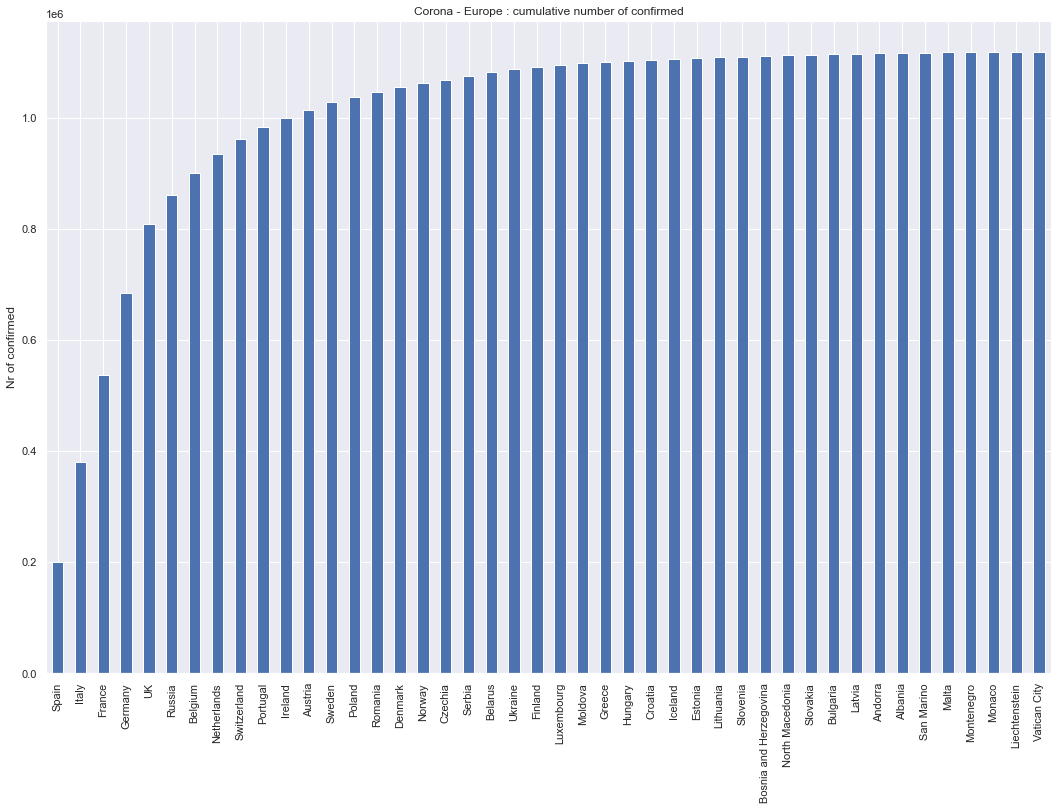

In [134]:
plt.figure(figsize=(18,12))
europe['confirmed'].cumsum().plot(kind='bar')
plt.title('Corona - Europe : cumulative number of confirmed')
plt.ylabel('Nr of confirmed')
plt.savefig('Corona_europe_cumulative.jpg',format='jpg')


In [135]:
def standardize(x):
    return (x - x.mean()) / x.std()

min_confirmed = 100
max_confirmed = 100000 # exclude e.g. China for better view

df_no_extrems = df.loc[ ( ( df['confirmed'] > min_confirmed  ) & ( df['confirmed'] < max_confirmed )) ]
df_no_extrems = df_no_extrems.loc[df_no_extrems['factor'] > 0]
df_no_extrems = df_no_extrems.loc[( 
    ( df_no_extrems['confirmed'] >= min_confirmed ) & (df_no_extrems['confirmed'] <= max_confirmed))]

df_no_extrems.drop(['South America','Oceania','Africa'],inplace=True)
print (df_no_extrems)

x = df_no_extrems['confirmed_per_M']
x = standardize(x)
y = df_no_extrems['factor']
y = standardize(y)

             confirmed  yesterday     inc  factor    dead  dead_inc  \
Russia         52763.0    47121.0  5642.0    1.12   456.0      51.0   
Brazil         40814.0    40743.0    71.0    1.00  2588.0       1.0   
Canada         36831.0    36829.0     2.0    1.00  1690.0       NaN   
India          18658.0    18539.0   119.0    1.01   592.0       NaN   
Israel         13883.0    13713.0   170.0    1.01   181.0       4.0   
S. Korea       10683.0    10674.0     9.0    1.00   237.0       1.0   
Pakistan        9216.0     8892.0   324.0    1.04   192.0      16.0   
Singapore       9125.0     8014.0  1111.0    1.14    11.0       NaN   
Mexico          8772.0     8261.0   511.0    1.06   712.0      26.0   
Czechia         6914.0     6900.0    14.0    1.00   196.0       2.0   
Australia       6642.0     6625.0    17.0    1.00    71.0       NaN   
Ukraine         6125.0     5710.0   415.0    1.07   161.0      10.0   
Panama          4658.0     4467.0   191.0    1.04   136.0      10.0   
Thaila

In [136]:
# 


print (y)

slope,intercept,_,_,_ = sps.linregress(x,y)

alpha_mu = 0
alpha_sigma = 1
beta_mu = 0
beta_sigma = 1


alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Uniform('sigma',lower=0.001,upper=2)

@pm.deterministic()
def linreq_mu(x=x,beta=beta,alpha=alpha):
    return x * beta + alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=y)

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
try:
    map_ = pm.MAP(model)
    map_.fit()
except:
    print ('cant fit model')

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})


Russia         2.64
Brazil        -0.93
Canada        -0.98
India         -0.79
Israel        -0.61
S. Korea      -0.96
Pakistan       0.12
Singapore      3.21
Mexico         0.89
Czechia       -0.92
Australia     -0.91
Ukraine        1.22
Panama         0.31
Thailand      -0.78
Hungary        0.75
Kazakhstan     0.90
Uzbekistan    -0.43
Oman           1.12
New Zealand   -0.88
Armenia        0.42
Lithuania     -0.44
Bulgaria       0.22
Latvia        -0.62
Niger         -0.66
Bolivia        0.84
Kyrgyzstan     0.19
Honduras       0.09
Taiwan        -0.77
Georgia       -0.53
DRC            0.66
Montenegro    -0.89
Sri Lanka     -0.49
Guatemala     -0.46
Mayotte        0.47
El Salvador   -0.01
China         -0.98
Name: factor, dtype: float64
 [-----------------100%-----------------] 10000 of 10000 complete in 16.2 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2.50e+03,2500.00,2500.00,2500.00
mean,2.00e-02,0.22,1.01,1.01
std,7.69e-02,0.17,0.13,0.13
min,-1.14e-01,-0.45,0.68,0.68
25%,-2.10e-04,0.11,0.92,0.92
50%,-1.48e-05,0.23,1.00,1.00
75%,1.55e-03,0.33,1.09,1.09
max,3.47e-01,0.76,1.81,1.81


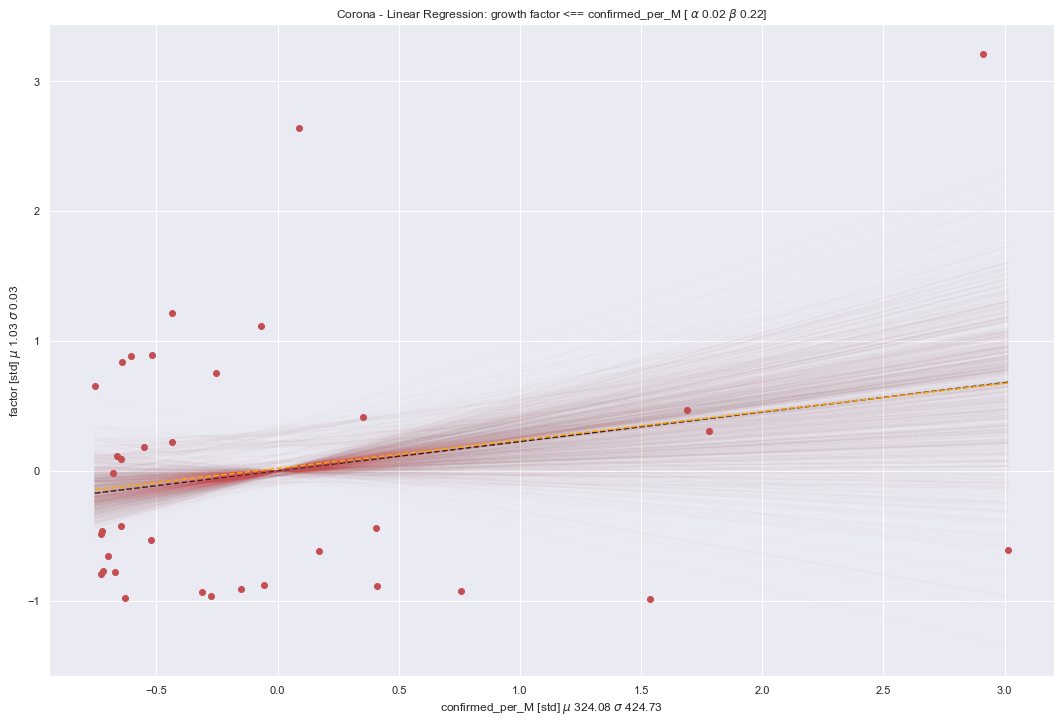

In [137]:

nr_rows = 100
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

X = np.linspace(x.min(),x.max(),nr_rows)

line_ys = np.array([X[i] * betas + alphas for i in range(len(X))])

plt.figure(figsize=(18,12))

line_alpha = result['alpha_post'].mean()
line_beta = result['beta_post'].mean()

plt.title(r'Corona - Linear Regression: growth factor <== confirmed_per_M [ $\alpha$ {:.2f} $\beta$ {:.2f}]'.format(
                                                                                        line_alpha,line_beta))

plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['factor'].mean(),
                                                              df_no_extrems['factor'].std()))
plt.xlabel(r'confirmed_per_M [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['confirmed_per_M'].mean(),
                                                             df_no_extrems['confirmed_per_M'].std()))
plt.scatter(x,y,color='r')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,line_ys,color='r',alpha = 0.01)
plt.plot(X,[X[i] * result['beta_post'].mean() + result['alpha_post'].mean() for i in range(len(X))],
        color='orange',ls='dashed')
result.describe()


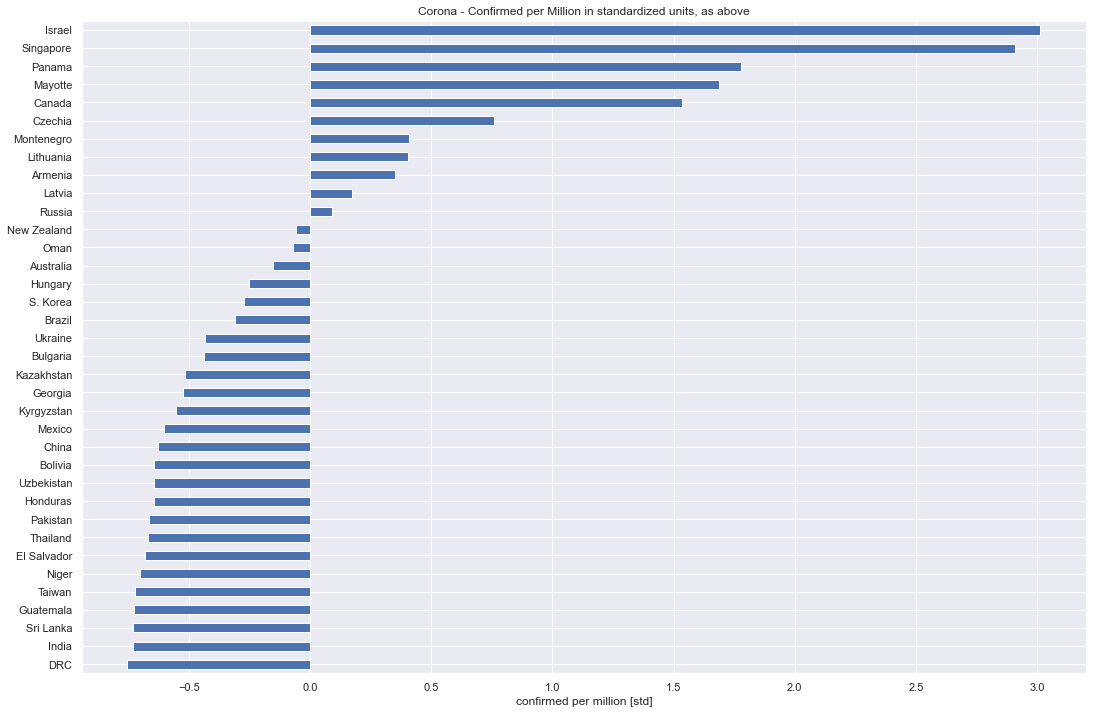

In [138]:
plt.figure(figsize=(18,12))
plt.title ('Corona - Confirmed per Million in standardized units, as above')
plt.xlabel('confirmed per million [std]')
#df_no_extrems['confirmed_per_M'].sort_values().plot(kind='barh')
std_values = standardize(df_no_extrems['confirmed_per_M'])
_= std_values.sort_values().plot(kind='barh')

